In [1]:
!pip install fastai
!pip install boto3
!pip install tqdm
!pip install timm
!pip install wandb
!pip install split-folders
!pip install gdown --upgrade
!pip install fastai==2.5.2 fastcore==1.3.26
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for gdown: filename=gdown-4.5.1-py3-none-any.whl size=14933 sha256=de5765c7ed5a677771068bfd8f34acf19354d09975444bb5de45bdc464115acc
  Stored in directory: c:\users\arrunpersonal\appdata\local\pip\cache\wheels\b8\79\f0\b523d25d96b0bbb12bb024b97940d08c4fcd498a00070c8d82
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [2]:
#!gdown "https://drive.google.com/drive/folders/1Q0UggEsjl2No375KHtbv-oYBmhzXn7Og?usp=sharing -O /tmp/folder --folder"

In [3]:
#!unzip "C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/RSI-CB256.zip"

In [1]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from fastai.vision.all import *
from fastai import *
import timm
from fastai.distributed import *

In [2]:
# import splitfolders
# splitfolders.ratio("C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/MLRSNET/Images", output="C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/MLRSNET_splitted",seed=42, ratio=(.8,.2), group_prefix=None, move=False) # default values

In [2]:
test_images_path = "C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/MLRSNET_splitted/val"
test_images = []
for i in os.listdir(test_images_path):
    for j in os.listdir(test_images_path + "/"+i):
        os.chdir(test_images_path + "/"+i)
        test_images.append(np.array(Image.open(j))/255)

In [3]:
len(test_images)

21842

In [4]:
test_dict = dict(zip(os.listdir(test_images_path),np.arange(len(os.listdir(test_images_path)))))

In [5]:
len(test_dict)

46

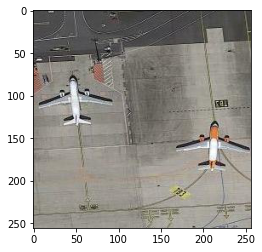

In [6]:
plt.imshow(test_images[0])
plt.show()

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


C:\Users\ArrunPersonal\anaconda3\lib\site-packages\torch\_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


Number of classes:  46


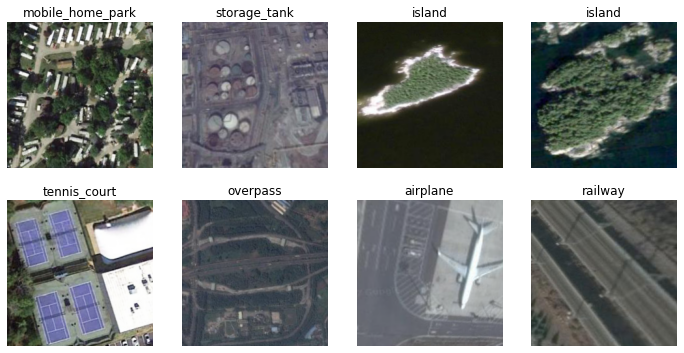

In [8]:
path = "C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/MLRSNET_splitted"
bs = 8
sz = 224

data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y= parent_label,
    splitter= GrandparentSplitter(train_name = "train",valid_name = "val"),
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75))

dls = data.dataloaders(path, bs=bs)
dls.show_batch()

print("Number of classes: ",dls.c)

#arch = "convnext_large_in22k"
arch = "swin_base_patch4_window7_224_in22k"
model = timm.create_model(arch, pretrained=True, in_chans=3, num_classes=0)
#model.head.fc = nn.Sequential(create_cls_module(nf=model.num_features, n_out=dls.c)) #convnext
model.head = nn.Sequential(create_cls_module(nf=model.num_features, n_out=dls.c)) #swin

In [9]:
learn = Learner(dls, model, metrics=[accuracy,Precision(average='macro'), Recall(average='macro'), F1Score(average='macro')])

In [10]:
learn.load("C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/Weights/MLRSNET/MLRSNET_splitted_swin_base_patch4_window7_224_in22k")
#learn.load("C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/Weights/MLRSNET/MLRSNET_splitted_convnext_large_in22k")
#learn.load("C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/Weights/WHU-RS19/WHU-RS19_splitted_efficientnet_b3")


C:\Users\ArrunPersonal\anaconda3\lib\site-packages\fastai\learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [11]:
del test_images

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

In [13]:
conf_mat = interp.confusion_matrix()

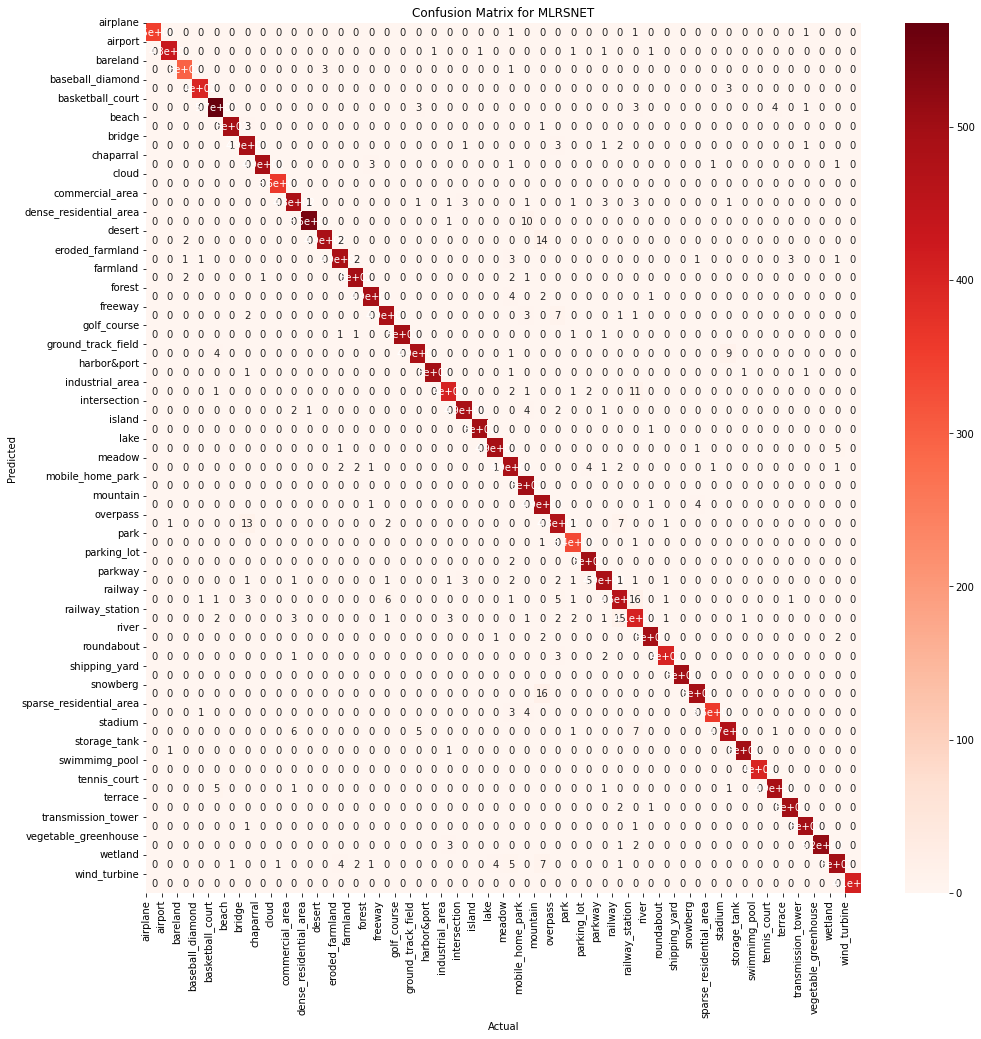

In [14]:
import seaborn as sns
plt.figure(figsize = (16,16))
sns.heatmap(conf_mat,annot = True,cmap = 'Reds')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.xticks(np.arange(len(test_dict)),test_dict.keys(),rotation = 90)
plt.yticks(np.arange(len(test_dict)),test_dict.keys(),rotation = 0)
plt.grid('on',which = 'minor')
plt.title("Confusion Matrix for MLRSNET")
plt.savefig("C:/Users/ArrunPersonal/Codes/SceneRecognition Remote Sensing/MLRSNET_Swin.jpeg",dpi = 300)
plt.show()